In [1]:
# 学习率调度器
''' 
到⽬前为⽌，我们主要关注如何更新权重向量的优化算法，⽽不是它们的更新速率。然⽽，调整学习率通常
与实际算法同样重要，有如下⼏⽅⾯需要考虑：
    • ⾸先，学习率的⼤⼩很重要。如果它太⼤，优化就会发散；如果它太⼩，训练就会需要过⻓时间，或者
    我们最终只能得到次优的结果。我们之前看到问题的条件数很重要（有关详细信息，请参⻅ 11.6节）。
    直观地说，这是最不敏感与最敏感⽅向的变化量的⽐率。
    • 其次，衰减速率同样很重要。如果学习率持续过⾼，我们可能最终会在最⼩值附近弹跳，从⽽⽆法达到
    最优解。11.5节⽐较详细地讨论了这⼀点，在 11.4节中我们则分析了性能保证。简⽽⾔之，我们希望速
    率衰减，但要⽐O(t− 1
    2 )慢，这样能成为解决凸问题的不错选择。
    • 另⼀个同样重要的⽅⾯是初始化。这既涉及参数最初的设置⽅式（详情请参阅 4.8节），⼜关系到它们
    最初的演变⽅式。这被戏称为预热（warmup），即我们最初开始向着解决⽅案迈进的速度有多快。⼀
    开始的⼤步可能没有好处，特别是因为最初的参数集是随机的。最初的更新⽅向可能也是毫⽆意义的。
    • 最后，还有许多优化变体可以执⾏周期性学习率调整。这超出了本章的范围，我们建议读者阅读 (Izmailov
    et al., 2018)来了解个中细节。例如，如何通过对整个路径参数求平均值来获得更好的解。
鉴于管理学习率需要很多细节，因此⼤多数深度学习框架都有⾃动应对这个问题的⼯具。在本章中，我们将
梳理不同的调度策略对准确性的影响，并展⽰如何通过学习率调度器（learning rate scheduler）来有效管理。
---------------------------------------------------------------------------------------------
我们从⼀个简单的问题开始，这个问题可以轻松计算，但⾜以说明要义。为此，我们选择了⼀个稍微现代
化的LeNet版本（激活函数使⽤relu⽽不是sigmoid，汇聚层使⽤最⼤汇聚层⽽不是平均汇聚层），并应⽤
于Fashion-MNIST数据集。此外，我们混合⽹络以提⾼性能。由于⼤多数代码都是标准的，我们只介绍基础
知识，⽽不做进⼀步的详细讨论。如果需要，请参阅 6节进⾏复习
'''
%matplotlib inline
import math
import torch
from torch import nn
from torch.optim import lr_scheduler
from d2l import torch as d2l

In [2]:
def net_fn(): # 定义网络
    return nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10),
    )

loss = nn.CrossEntropyLoss()
device = d2l.try_gpu()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 代码⼏乎与d2l.train_ch6定义在卷积神经⽹络⼀章LeNet⼀节中的相同
def train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler=None):
    net.to(device)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        # train_loss,train_acc,num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                            (train_loss, train_acc, None))
    
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
    
    if scheduler: # 调度器
        if scheduler.__module__ == lr_scheduler.__name__:
            # UsingPyTorchIn-Builtscheduler 使用官方调度器
            scheduler.step()
        else:   
            # Usingcustomdefinedscheduler 使用自定义调度器
            for param_group in trainer.param_groups:
                param_group['lr'] = scheduler(epoch)

    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
        f'test acc {test_acc:.3f}')

train loss 0.163, train acc 0.937, test acc 0.884


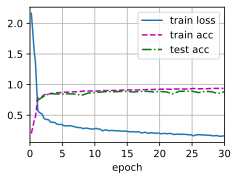

In [3]:
'''让我们来看看如果使⽤默认设置，调⽤此算法会发⽣什么。例如设学习率为0.3并训练30次迭代。留意在超过
了某点、测试准确度⽅⾯的进展停滞时，训练准确度将如何继续提⾼。两条曲线之间的间隙表⽰过拟合
'''
lr, num_epochs = 0.3, 30
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

In [4]:
# 学习率调度器
''' 
我们可以在每个迭代轮数（甚⾄在每个⼩批量）之后向下调整学习率。例如，以动态的⽅式来响应优化的进
展情况
'''
lr = 0.1
trainer.param_groups[0]["lr"] = lr
print(f'learning rate is now {trainer.param_groups[0]["lr"]:.2f}')

learning rate is now 0.10


In [5]:
'''更通常⽽⾔，我们应该定义⼀个调度器。当调⽤更新次数时，它将返回学习率的适当值。让我们定义⼀个简
单的⽅法，将学习率设置为η = η0(t + 1)^−1/2
'''
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr
        
    # __call__() 使得类实例对象可以像调用普通函数那样以“对象名()”的形式使用
    def __call__(self, num_update): 
        return self.lr * pow(num_update + 1.0, -0.5) # 设置学习率

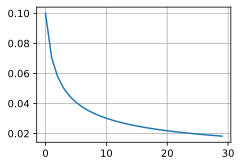

In [6]:
scheduler = SquareRootScheduler(lr=0.1) # 调用平方根调度器
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.197, train acc 0.927, test acc 0.883


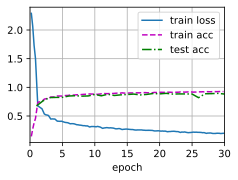

In [7]:
'''现在让我们来看看这对在Fashion-MNIST数据集上的训练有何影响。我们只是提供调度器作为训练算法的额
外参数
-----------------------------------------------------------------------------------------
这⽐以前好⼀些：曲线⽐以前更加平滑，并且过拟合更⼩了。遗憾的是，关于为什么在理论上某些策略会导
致较轻的过拟合，有⼀些观点认为，较⼩的步⻓将导致参数更接近零，因此更简单。但是，这并不能完全解
释这种现象，因为我们并没有真正地提前停⽌，⽽只是轻柔地降低了学习率
'''
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

In [8]:
# 策略
''' 
虽然我们不可能涵盖所有类型的学习率调度器，但我们会尝试在下⾯简要概述常⽤的策略：多项式衰减和分
段常数表。此外，余弦学习率调度在实践中的⼀些问题上运⾏效果很好。在某些问题上，最好在使⽤较⾼的
学习率之前预热优化器。
--------------------------------------------------------------------------------------
单因⼦调度器 -> 多项式衰减
多项式衰减的⼀种替代⽅案是乘法衰减，即 ηt+1 ← ηt·α其中α ∈ (0, 1)。为了防⽌学习率衰减到⼀个合理的
下界之下，更新⽅程经常修改为 ηt+1 ← max(ηmin, ηt·α)
'''
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr # 停止学习率
        self.base_lr = base_lr # 基础学习率
        
    def __call__(self, num_update): # 单因子调度器
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

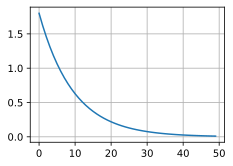

In [9]:
scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
d2l.plot(torch.arange(50), [scheduler(t) for t in range(50)])

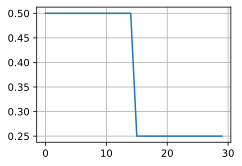

In [10]:
# 多因子调度器 -> 分段常数表
''' 
接下来，我们将使⽤内置的调度器，在这⾥仅解释它们的功能:
训练深度网络的常⻅策略之⼀是保持学习率为⼀组分段的常量，并且不时地按给定的参数对学习率做乘法衰
减。具体地说，给定⼀组降低学习率的时间点，例如s = {5, 10, 20}，每当t ∈ s时，降低ηt+1 ← ηt·α
假设每步中的值减半，我们可以按如下⽅式实现这⼀点
'''
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
scheduler = lr_scheduler.MultiStepLR(trainer, milestones=[15, 30], gamma=0.5) # 多段调度

def get_lr(trainer, scheduler):
    lr = scheduler.get_last_lr()[0]
    trainer.step()
    scheduler.step()
    return lr
d2l.plot(torch.arange(num_epochs), [get_lr(trainer, scheduler)
                                    for t in range(num_epochs)])

train loss 0.193, train acc 0.927, test acc 0.897


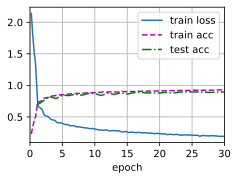

In [11]:
'''这种分段恒定学习率调度背后的直觉是，让优化持续进⾏，直到权重向量的分布达到⼀个驻点。此时，我们
才将学习率降低，以获得更⾼质量的代理来达到⼀个良好的局部最⼩值。下⾯的例⼦展⽰了如何使⽤这种⽅
法产⽣更好的解决⽅案
'''
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

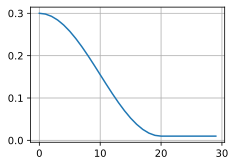

In [12]:
# 余弦调度器
''' 
余弦调度器是 (Loshchilov and Hutter, 2016)提出的⼀种启发式算法。它所依据的观点是：我们可能不想在⼀
开始就太⼤地降低学习率，⽽且可能希望最终能⽤⾮常⼩的学习率来“改进”解决⽅案。这产⽣了⼀个类似
于余弦的调度，函数形式如下所⽰，学习率的值在t ∈ [0, T]之间
ηt = ηT + (η0 − ηT)(1 + cos(πt/T))/2
这⾥η0是初始学习率，ηT 是当T时的⽬标学习率。此外，对于t > T，我们只需将值固定到ηT ⽽不再增加它。
在下⾯的⽰例中，我们设置了最⼤更新步数T = 20
'''
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
                 warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps
        
    def get_warmup_lr(self, epoch): # 预热
        # 在 warmup_steps 增长到 base_lr_orig
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
            * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase
    
    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update: # t < T, 增加学习率
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr # t > T，将学习率固定到ηT⽽不再增加它

# 最⼤更新步数T = 20
scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.182, train acc 0.929, test acc 0.886


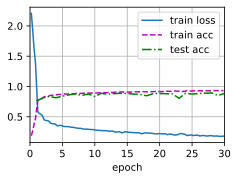

In [13]:
'在计算机视觉的背景下，这个调度⽅式可能产⽣改进的结果。但请注意，如下所⽰，这种改进并不⼀定成⽴'
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

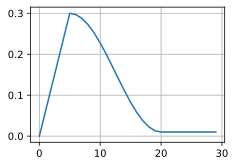

In [15]:
# 预热
''' 
在某些情况下，初始化参数不⾜以得到良好的解。这对某些⾼级⽹络设计来说尤其棘⼿，可能导致不稳定的
优化结果。对此，⼀⽅⾯，我们可以选择⼀个⾜够⼩的学习率，从⽽防⽌⼀开始发散，然⽽这样进展太缓慢。
另⼀⽅⾯，较⾼的学习率最初就会导致发散。
解决这种困境的⼀个相当简单的解决⽅法是使⽤预热期，在此期间学习率将增加⾄初始最⼤值，然后冷却直
到优化过程结束。为了简单起⻅，通常使⽤线性递增。这引出了如下表所⽰的时间表
'''
# 在 warmup_steps=5 时增长到 base_lr=0.3, 然后衰减直至 final_lr=0.01
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.155, train acc 0.941, test acc 0.891


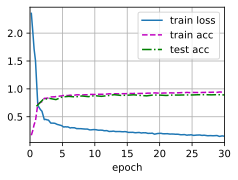

In [16]:
'''注意，观察前5个迭代轮数的性能，⽹络最初收敛得更好
预热可以应⽤于任何调度器，⽽不仅仅是余弦。有关学习率调度的更多实验和更详细讨论，请参阅 (Gotmare
et al., 2018)。其中，这篇论⽂的点睛之笔的发现：预热阶段限制了⾮常深的网络中参数的发散程度。这在直
觉上是有道理的：在网络中那些⼀开始花费最多时间取得进展的部分，随机初始化会产⽣巨⼤的发散
'''
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

In [ ]:
''' 
⼩结
• 在训练期间逐步降低学习率可以提⾼准确性，并且减少模型的过拟合
• 在实验中，每当进展趋于稳定时就降低学习率，这是很有效的。从本质上说，这可以确保我们有效地收
敛到⼀个适当的解，也只有这样才能通过降低学习率来减⼩参数的固有⽅差
• 余弦调度器在某些计算机视觉问题中很受欢迎
• 优化之前的预热期可以防⽌发散
• 优化在深度学习中有多种⽤途。对于同样的训练误差⽽⾔，选择不同的优化算法和学习率调度，除了最
⼤限度地减少训练时间，可以导致测试集上不同的泛化和过拟合量
'''